In [6]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [57]:
from cnn_training import CNN

It's always worth checking how the loss behaved during training.
We saved a running loss every couple hundret of optimization steps, which we can load and plot now.

In [1]:
import pickle

with open('losses.pkl', 'rb') as file:
    losses_list = pickle.load(file)

losses = [i/1000 for i in losses_list]
step_num = [i+1 for i in range(len(losses))]

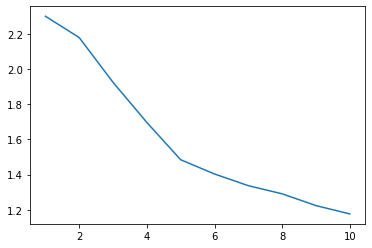

In [7]:
plt.plot(step_num,losses)

This looks like a pretty smooth minimization curve. Sometimes you might see divergent behavior, which means you should try a smaller step size fot SGD.

In [9]:
# lets load the test data
import torchvision
transformation = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

test_data = torchvision.datasets.CIFAR10(root='./data',train=False,download=False, transform=transformation)


In [10]:
# cifar10 contains 32x32 colored images of these types
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_loader = torch.utils.data.DataLoader(test_data,
                            batch_size=3,
                            shuffle=True,         
                            num_workers=2)        

dataiter = iter(test_loader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



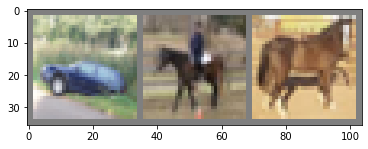

labels:  car   horse horse


In [12]:
imshow(torchvision.utils.make_grid(images))
print('labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

In [15]:
# load trained model
model = CNN()
model.load_state_dict(torch.load('./trained_model'))
model.eval() # now gradient computation is disabled saving alot of memory
device = 'cuda:0' if torch.cuda.is_available else 'cpu'
model.to(device)


CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [16]:
predictions = model(images.to(device))

predictions # have dimensionality [batchsize, n_classes]

tensor([[2.6840, 3.3708, 1.0551, 0.9956, 0.9884, 0.0000, 1.5553, 0.0000, 3.3477,
         2.8349],
        [3.5531, 0.0000, 4.9120, 5.0103, 6.5172, 6.1996, 2.1803, 7.7703, 0.0000,
         1.8431],
        [2.5513, 0.0000, 5.4514, 5.5665, 6.2143, 6.0815, 5.6618, 7.4273, 0.0000,
         1.7669]], device='cuda:0', grad_fn=<ReluBackward0>)

In [17]:
activation, indices = torch.max(predictions,1)

for i in indices.cpu().numpy():
    print(classes[i])



car
horse
horse


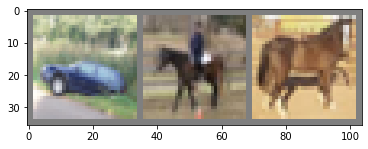

labels:  car   horse horse


In [18]:
# print images
imshow(torchvision.utils.make_grid(images))
print('labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

So here all three predictions are correct.

In [41]:
def get_accuracy(model,dataloader,device):
    '''calculates the accuracy of a model on a sample provided by dataloader'''
    correct = 0
    total   = 0

    model.to(device)

    with torch.no_grad(): # disable gradient computation to save memory
        for i,batch in enumerate(dataloader):
            input, label = batch
            input, label = input.to(device), label.to(device)
            output = model(input)
            _, predicted = torch.max(output.data,1) # get max activation
            total += label.size(0)
            correct += (predicted == label).sum().item()


            return correct / total



In [42]:
acc_test = get_accuracy(model,test_loader,device)

In [55]:
print("Estimated accuracy on the test set is ", round(acc_test*100,3), "%")

Estimated accuracy on the test set is  66.667 %


Note that random chance would be around 10%, so the network definitly learned something.